In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set random seed for reproducibility
# np.random.seed(48)

In [2]:
data = pd.read_csv('impedance_data.csv')
frequencies = data['Frequency']  # Hz
Z_real_measured = data['Z_real']  # Real part of impedance
Z_imag_measured = data['Z_imag']  # Imaginary part of impedance


In [3]:
def impedance_model(frequencies, Rs, R, C):
    """
    Calculate real and imaginary impedance based on circuit model.
    """
    omega = 2 * np.pi * frequencies  # Angular frequency
    Z_real = Rs + R / (1 + (omega * R * C)**2)
    Z_imag = -omega * R * C**2 / (1 + (omega * R * C)**2)
    return Z_real, Z_imag


In [4]:
# def log_likelihood(params, frequencies, Z_real_measured, Z_imag_measured, sigma=1):
#     """
#     Compute log-likelihood for the model given parameters.
#     """
#     Rs, R, C = params
#     Z_real_theory, Z_imag_theory = impedance_model(frequencies, Rs, R, C)
    
#     # Residuals
#     delta_real = Z_real_measured - Z_real_theory
#     delta_imag = Z_imag_measured - Z_imag_theory
    
#     # Log-likelihood
#     return -0.5 * np.sum((delta_real / sigma)**2 + (delta_imag / sigma)**2)



def log_likelihood(params, frequencies, Z_real_measured, Z_imag_measured, sigma=10):
    """
    Compute the full log-likelihood for the model given parameters.
    """
    Rs, R, C = params
    Z_real_theory, Z_imag_theory = impedance_model(frequencies, Rs, R, C)
    
    # Residuals
    delta_real = Z_real_measured - Z_real_theory
    delta_imag = Z_imag_measured - Z_imag_theory
    
    N = len(frequencies)  # Number of data points
    
    # Log-likelihood
    return (
        -0.5 * N * np.log(2 * np.pi) 
        - N * np.log(sigma) 
        - 0.5 * np.sum((delta_real / sigma)**2 + (delta_imag / sigma)**2)
    )



In [5]:
def metropolis(frequencies, Z_real_measured, Z_imag_measured, n_steps, sigma=10):
    """
    Perform Metropolis sampling to estimate Rs, R, and C.
    Tracks and computes the acceptance rate.
    """
    # Initialize parameters
    Rs_current = 700.0  # Initial guess for Rs , 150 Ohm
    R_current = 150.0   # Initial guess for R  , 150 Ohm
    C_current = 1e-5    # Initial guess for C  , 1e-5 uF
    params_current = [Rs_current, R_current, C_current]
    
    # Initialize likelihood
    log_likelihood_current = log_likelihood(params_current, frequencies, Z_real_measured, Z_imag_measured, sigma)
    
    # Storage for results
    samples = []
    accepted = 0  # Counter for accepted proposals
    
    # Proposal standard deviation
    proposal_std = [0.1, 0.1, 1e-9]  # Standard deviations for Rs, R, C
    
    for step in range(n_steps):
        # Propose new parameters
        Rs_new = np.random.normal(Rs_current, proposal_std[0])
        R_new = np.random.normal(R_current, proposal_std[1])
        C_new = np.random.normal(C_current, proposal_std[2])
        params_new = [Rs_new, R_new, C_new]
        
        # Calculate new likelihood
        log_likelihood_new = log_likelihood(params_new, frequencies, Z_real_measured, Z_imag_measured, sigma)
        
        # Acceptance ratio
        # alpha = np.exp(log_likelihood_new - log_likelihood_current)
        alpha = min(1, log_likelihood_new - log_likelihood_current)

        
        # Accept/reject step
        if np.random.rand() < alpha:
            Rs_current, R_current, C_current = Rs_new, R_new, C_new
            log_likelihood_current = log_likelihood_new
            accepted += 1  # Increment accepted proposals count
        
        # Store sample
        samples.append([Rs_current, R_current, C_current])
    
    # Calculate acceptance rate
    acceptance_rate = accepted / n_steps
    
    return np.array(samples), acceptance_rate


In [6]:
n_steps = 10000
# samples = metropolis(frequencies, Z_real_measured, Z_imag_measured, n_steps)

samples, acceptance_rate = metropolis(frequencies, Z_real_measured, Z_imag_measured, n_steps)

# Print acceptance rate
print(f"Acceptance Rate: {acceptance_rate * 100:.2f}%")

# Extract samples
Rs_samples = samples[:, 0]
R_samples = samples[:, 1]
C_samples = samples[:, 2]


Acceptance Rate: 48.78%


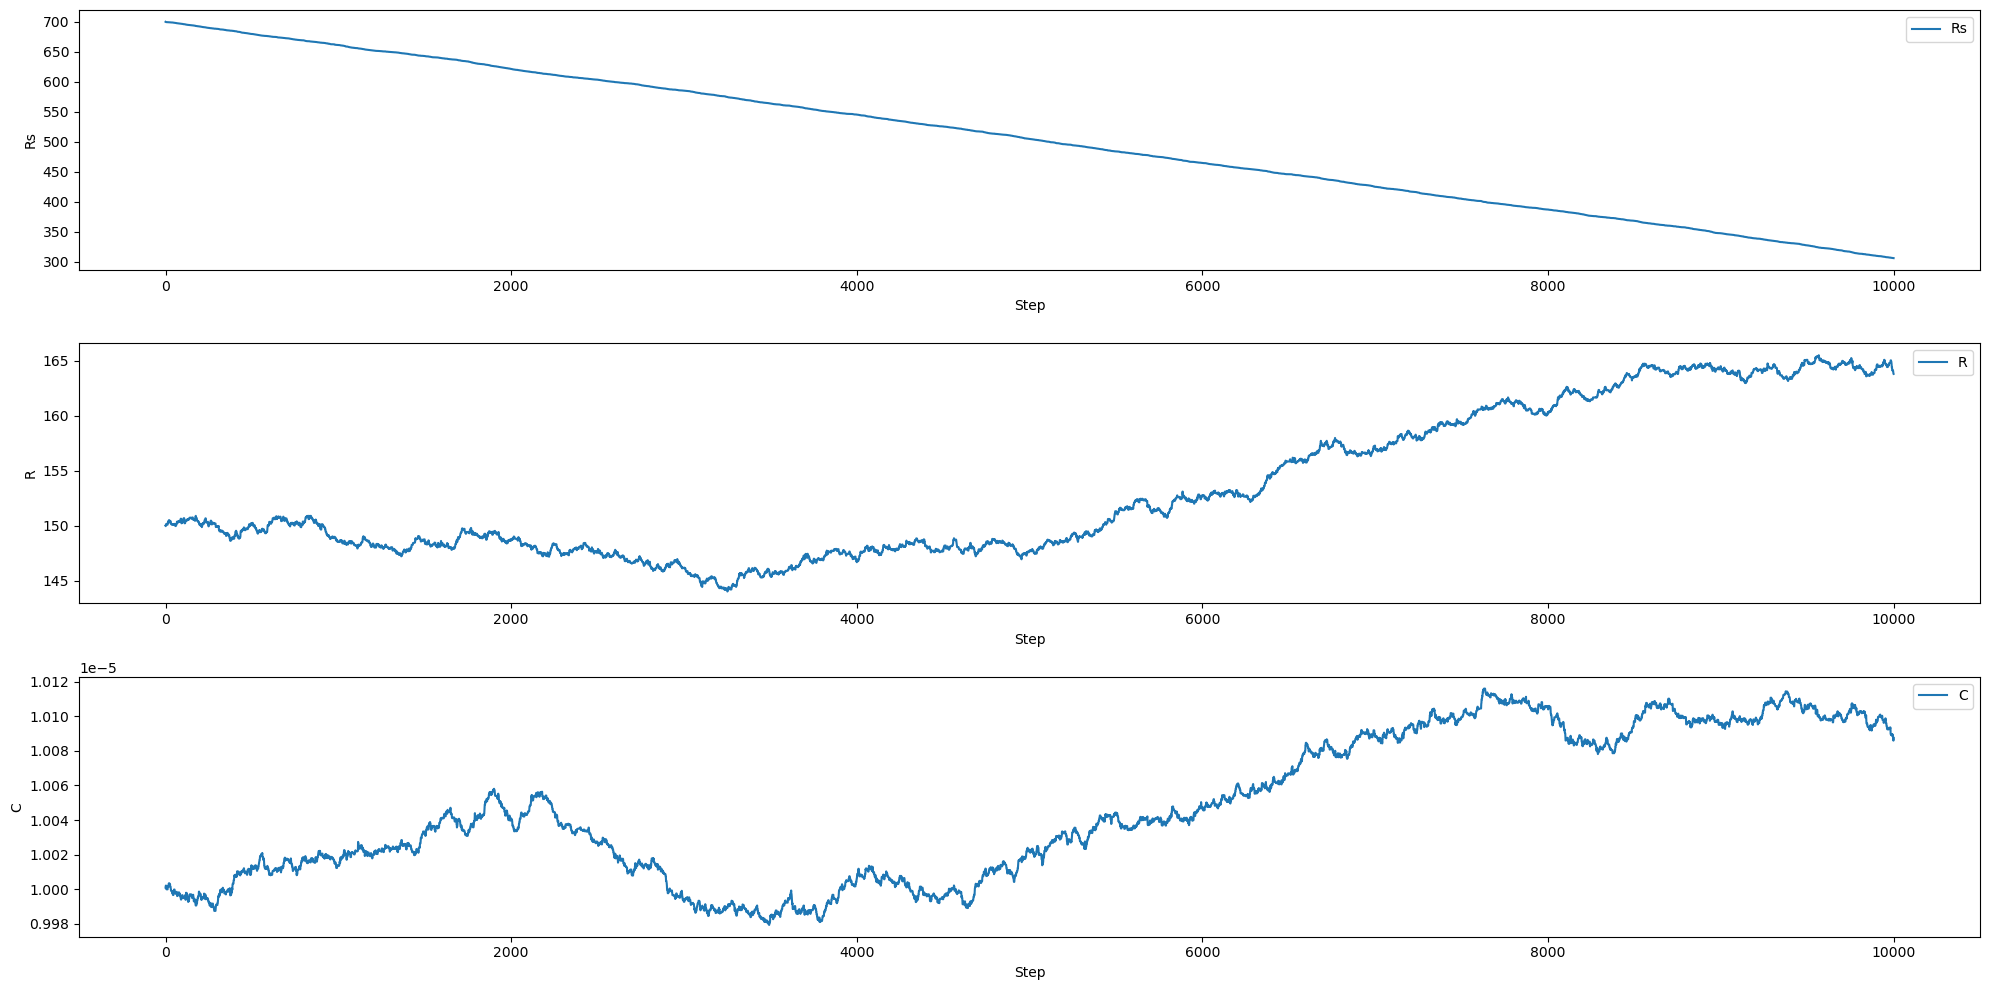

In [7]:
plt.figure(figsize=(20, 10))

# Trace plot for Rs
plt.subplot(3, 1, 1)
plt.plot(Rs_samples, label='Rs')
plt.xlabel('Step')
plt.ylabel('Rs')
plt.legend()

# Trace plot for R
plt.subplot(3, 1, 2)
plt.plot(R_samples, label='R')
plt.xlabel('Step')
plt.ylabel('R')
plt.legend()

# Trace plot for C
plt.subplot(3, 1, 3)
plt.plot(C_samples, label='C')
plt.xlabel('Step')
plt.ylabel('C')
plt.legend()

plt.tight_layout()
plt.show()

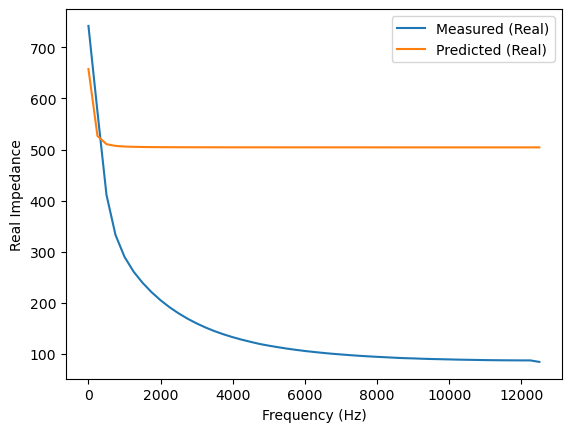

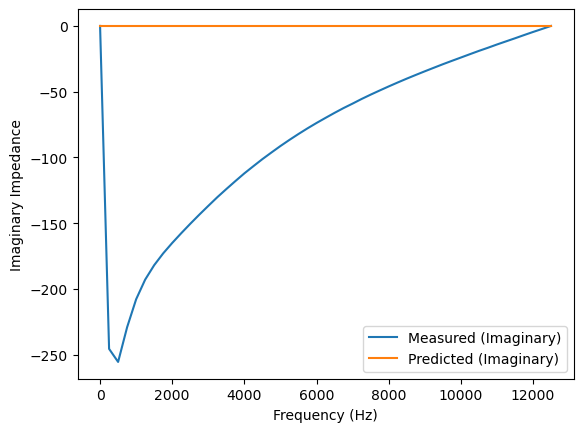

In [8]:
# import corner
# corner.corner(samples, labels=["Rs", "R", "C"], truths=[150, 150, 1e-5]) # true values were Rs=100, R=100, C=1e-6
# plt.show()

# Plot predicted vs measured
best_params = np.mean(samples, axis=0)
Z_real_pred, Z_imag_pred = impedance_model(frequencies, *best_params)

plt.figure()
plt.plot(frequencies, Z_real_measured, label="Measured (Real)")
plt.plot(frequencies, Z_real_pred, label="Predicted (Real)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Real Impedance")
plt.legend()
plt.show()

plt.figure()
plt.plot(frequencies, Z_imag_measured, label="Measured (Imaginary)")
plt.plot(frequencies, Z_imag_pred, label="Predicted (Imaginary)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Imaginary Impedance")
plt.legend()
plt.show()


Rs: Mean = 504.3437, Std = 113.5702
R: Mean = 153.2270, Std = 6.5478
C: Mean = 0.0000, Std = 0.0000


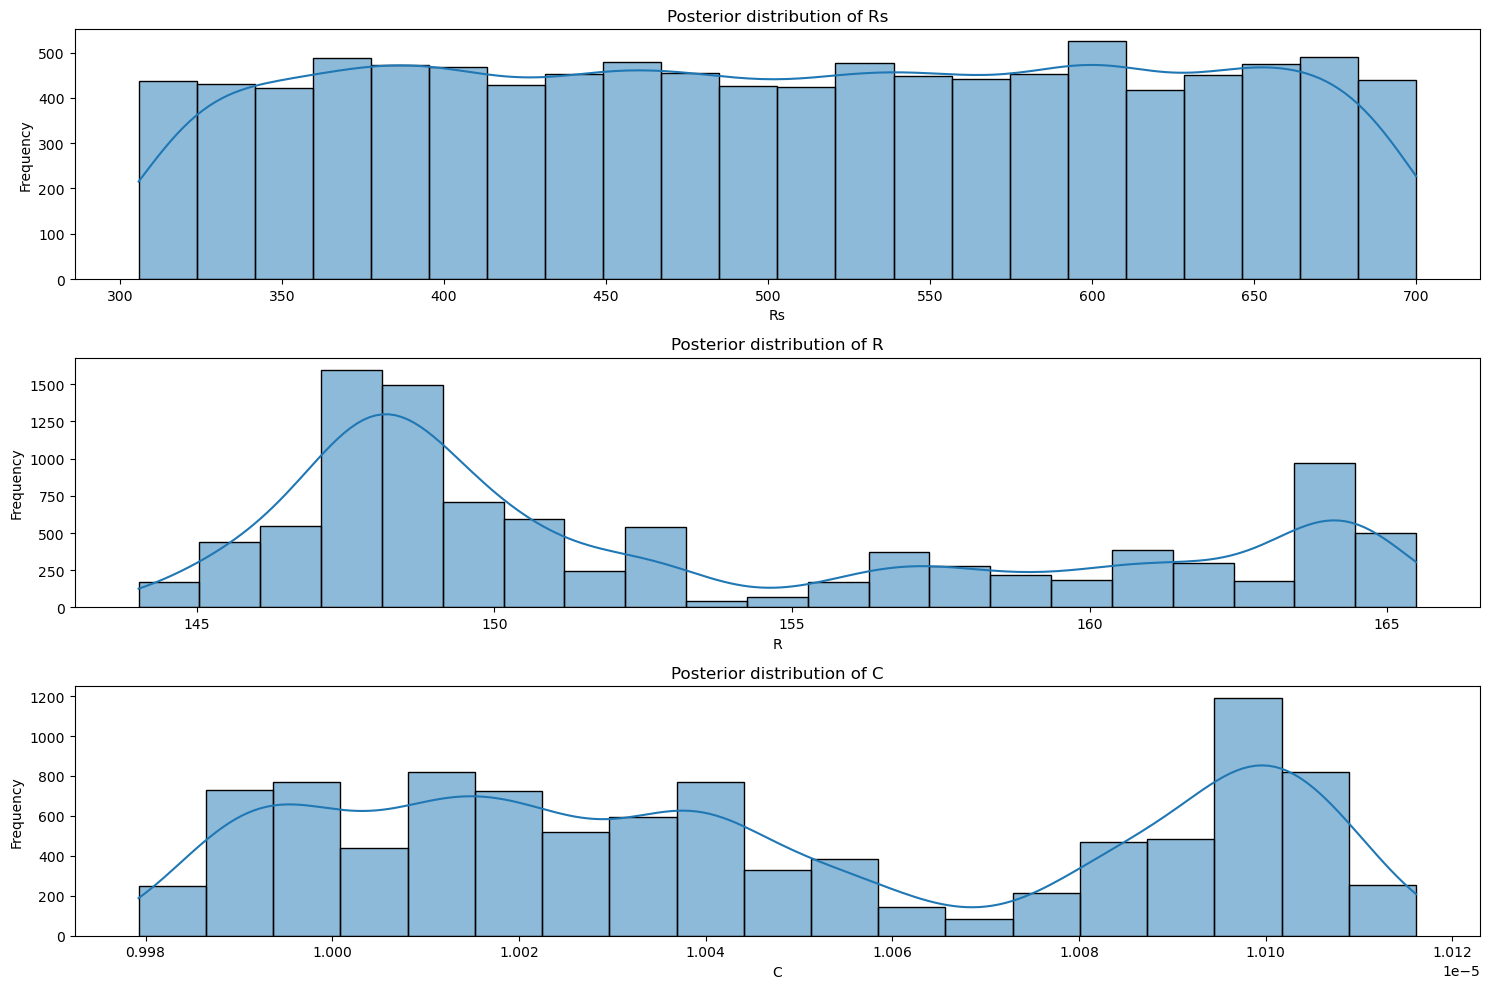

In [9]:
import seaborn as sns

# Function to plot histograms and calculate summary statistics
def analyze_posterior(samples, param_names):
    """
    Analyze the posterior distributions of the sampled parameters.
    
    Parameters:
    samples (numpy.ndarray): Array of sampled parameters.
    param_names (list): List of parameter names.
    """
    num_params = samples.shape[1]
    plt.figure(figsize=(15, 10))
    
    for i in range(num_params):
        plt.subplot(num_params, 1, i + 1)
        sns.histplot(samples[:, i], kde=True)
        plt.title(f'Posterior distribution of {param_names[i]}')
        plt.xlabel(param_names[i])
        plt.ylabel('Frequency')
        
        mean = np.mean(samples[:, i])
        std = np.std(samples[:, i])
        print(f'{param_names[i]}: Mean = {mean:.4f}, Std = {std:.4f}')
    
    plt.tight_layout()
    plt.show()

# Parameter names
param_names = ["Rs", "R", "C"]

# Analyze posterior distributions
analyze_posterior(samples, param_names)

In [10]:
# Compute the log-likelihood for the best parameters
log_likelihood_value = log_likelihood(best_params, frequencies, Z_real_measured, Z_imag_measured)

# Print the log-likelihood value
print(f"Log-Likelihood: {log_likelihood_value}")

Log-Likelihood: -38064.16659802309


----

Acceptance Rate: 52.10%


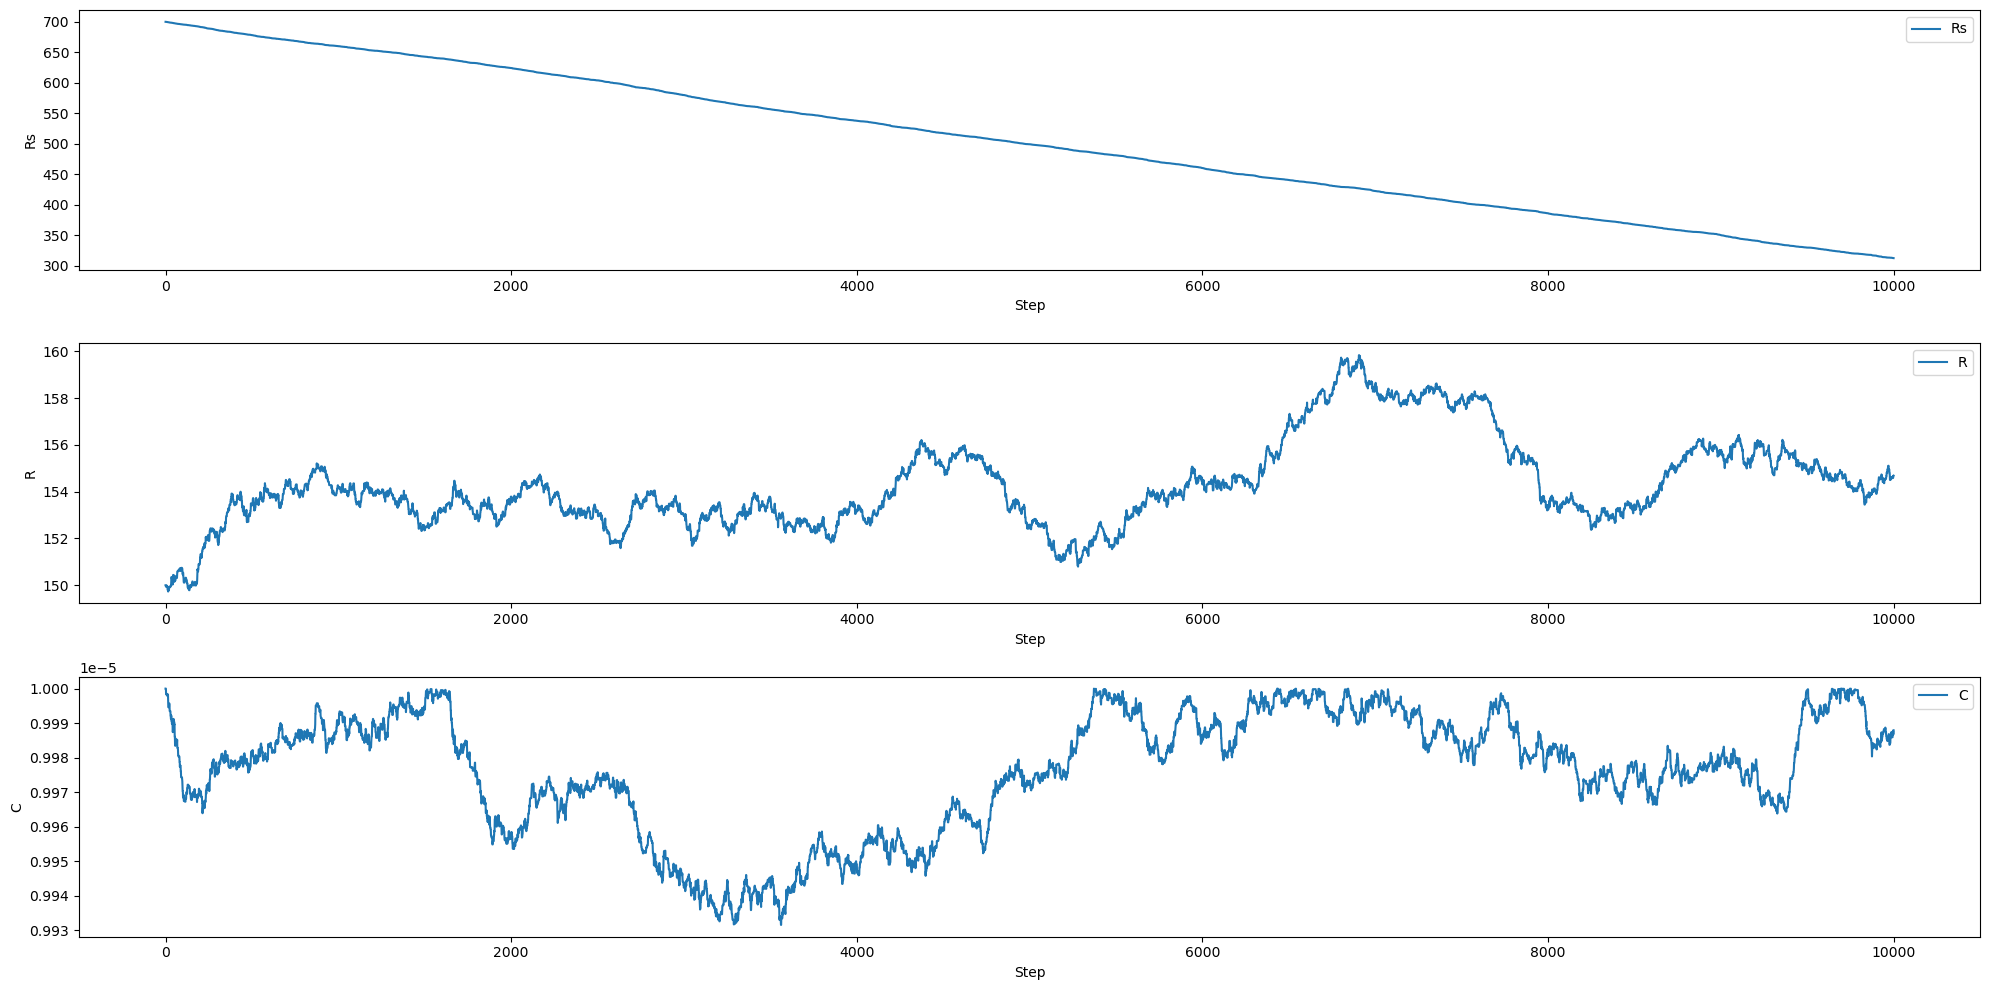

In [11]:

# Load data
data = pd.read_csv('circuit1_data.csv')
frequencies = data['Frequency']  # Hz
Z_real_measured = data['Z_real']  # Real part of impedance
Z_imag_measured = data['Z_imag']  # Imaginary part of impedance


# Step 1: Circuit Impedance Model
def impedance_model(frequencies, Rs, R, C):
    """
    Calculate real and imaginary impedance based on circuit model.
    """
    omega = 2 * np.pi * frequencies  # Angular frequency
    Z_real = Rs + R / (1 + (omega * R * C)**2)
    Z_imag = -omega * R**2 * C / (1 + (omega * R * C)**2)
    return Z_real, Z_imag


# Step 2: Define the Prior
def log_prior(Rs, R, C):
    """
    Log-prior for parameters Rs, R, C.
    Assumes uniform priors within specified ranges.
    """
    if 100 <= Rs <= 10000 and 100 <= R <= 10000 and 1e-9 <= C <= 1e-5:
        return 0  # Uniform prior: constant probability
    else:
        return -np.inf  # Outside bounds: invalid


# Step 3: Define the Likelihood
def log_likelihood(params, frequencies, Z_real_measured, Z_imag_measured, sigma=10):
    """
    Compute the full log-likelihood for the model given parameters.
    """
    Rs, R, C = params
    Z_real_theory, Z_imag_theory = impedance_model(frequencies, Rs, R, C)
    
    # Residuals
    delta_real = Z_real_measured - Z_real_theory
    delta_imag = Z_imag_measured - Z_imag_theory
    
    N = len(frequencies)  # Number of data points
    
    # Log-likelihood
    return (
        -0.5 * N * np.log(2 * np.pi) 
        - N * np.log(sigma) 
        - 0.5 * np.sum((delta_real / sigma)**2 + (delta_imag / sigma)**2)
    )


# Step 4: Define the Posterior
def log_posterior(params, frequencies, Z_real_measured, Z_imag_measured, sigma=10):
    """
    Compute the log-posterior (log_prior + log_likelihood).
    """
    Rs, R, C = params
    lp = log_prior(Rs, R, C)  # Prior term
    if np.isinf(lp):  # Invalid prior -> posterior is invalid
        return -np.inf
    
    ll = log_likelihood(params, frequencies, Z_real_measured, Z_imag_measured, sigma)
    return lp + ll  # Posterior = Prior + Likelihood


# Step 5: Metropolis Sampling
def metropolis(frequencies, Z_real_measured, Z_imag_measured, n_steps, sigma=10):
    """
    Perform Metropolis sampling to estimate Rs, R, and C.
    Tracks and computes the acceptance rate.
    """
    # Initialize parameters
    Rs_current = 700.0  # Initial guess for Rs
    R_current = 150.0   # Initial guess for R
    C_current = 1e-5    # Initial guess for C
    params_current = [Rs_current, R_current, C_current]
    
    # Initialize posterior
    log_posterior_current = log_posterior(params_current, frequencies, Z_real_measured, Z_imag_measured, sigma)
    
    # Storage for results
    samples = []
    accepted = 0  # Counter for accepted proposals
    
    # Proposal standard deviation
    proposal_std = [0.1, 0.1, 1e-9]  # Standard deviations for Rs, R, C
    
    for step in range(n_steps):
        # Propose new parameters
        Rs_new = np.random.normal(Rs_current, proposal_std[0])
        R_new = np.random.normal(R_current, proposal_std[1])
        C_new = np.random.normal(C_current, proposal_std[2])
        params_new = [Rs_new, R_new, C_new]
        
        # Calculate new posterior
        log_posterior_new = log_posterior(params_new, frequencies, Z_real_measured, Z_imag_measured, sigma)
        
        # Acceptance ratio
        alpha = np.exp(log_posterior_new - log_posterior_current)
        alpha = min(1, alpha)  # Ensure alpha is at most 1
        
        # Accept/reject step
        if np.random.rand() < alpha:
            Rs_current, R_current, C_current = Rs_new, R_new, C_new
            log_posterior_current = log_posterior_new
            accepted += 1  # Increment accepted proposals count
        
        # Store sample
        samples.append([Rs_current, R_current, C_current])
    
    # Calculate acceptance rate
    acceptance_rate = accepted / n_steps
    
    return np.array(samples), acceptance_rate


# Step 6: Run the Metropolis Algorithm
n_steps = 10000
samples, acceptance_rate = metropolis(frequencies, Z_real_measured, Z_imag_measured, n_steps)

# Step 7: Plot Results
print(f"Acceptance Rate: {acceptance_rate * 100:.2f}%")

# Extract samples
Rs_samples = samples[:, 0]
R_samples = samples[:, 1]
C_samples = samples[:, 2]

plt.figure(figsize=(20, 10))

# Trace plot for Rs
plt.subplot(3, 1, 1)
plt.plot(Rs_samples, label='Rs')
plt.xlabel('Step')
plt.ylabel('Rs')
plt.legend()

# Trace plot for R
plt.subplot(3, 1, 2)
plt.plot(R_samples, label='R')
plt.xlabel('Step')
plt.ylabel('R')
plt.legend()

# Trace plot for C
plt.subplot(3, 1, 3)
plt.plot(C_samples, label='C')
plt.xlabel('Step')
plt.ylabel('C')
plt.legend()

plt.tight_layout()
plt.show()


---

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('circuit1_data.csv')
frequencies = data['Frequency'].values  # Hz
Z_real_measured = data['Z_real'].values  # Real part of impedance
Z_imag_measured = data['Z_imag'].values  # Imaginary part of impedance

### ================== METROPOLIS FOR CIRCUIT A ==================
def log_likelihood_a(params, frequencies, Z_real_measured, Z_imag_measured, sigma=10):
    Rs, R, C = params
    omega = 2 * np.pi * frequencies
    Z_real_theory = Rs + R / (1 + (omega * R * C)**2)
    Z_imag_theory = -omega * R**2 * C / (1 + (omega * R * C)**2)
    delta_real = Z_real_measured - Z_real_theory
    delta_imag = Z_imag_measured - Z_imag_theory
    return -0.5 * np.sum((delta_real / sigma)**2 + (delta_imag / sigma)**2)

def metropolis_a(n_steps):
    params = [700.0, 150.0, 1e-5]  # Initial guesses
    proposal_std = [10, 10, 1e-7]  # Step sizes for Rs, R, C
    samples = []
    log_likelihoods = []
    
    current_log_likelihood = log_likelihood_a(params, frequencies, Z_real_measured, Z_imag_measured)
    
    for step in range(n_steps):
        proposed_params = np.random.normal(params, proposal_std)
        proposed_log_likelihood = log_likelihood_a(proposed_params, frequencies, Z_real_measured, Z_imag_measured)
        
        if np.random.rand() < np.exp(proposed_log_likelihood - current_log_likelihood):
            params = proposed_params
            current_log_likelihood = proposed_log_likelihood
        
        samples.append(params)
        log_likelihoods.append(current_log_likelihood)
    
    return np.array(samples), np.array(log_likelihoods)


### ================== METROPOLIS FOR CIRCUIT B ==================
def log_likelihood_b(params, frequencies, Z_real_measured, Z_imag_measured, sigma=10):
    Rs, R1, R2, C1, C2 = params
    omega = 2 * np.pi * frequencies
    Z_real_theory = Rs + R1 / (1 + (omega * R1 * C1)**2) + R2 / (1 + (omega * R2 * C2)**2)
    Z_imag_theory = - (omega * R1**2 * C1 / (1 + (omega * R1 * C1)**2)) - (omega * R2**2 * C2 / (1 + (omega * R2 * C2)**2))
    delta_real = Z_real_measured - Z_real_theory
    delta_imag = Z_imag_measured - Z_imag_theory
    return -0.5 * np.sum((delta_real / sigma)**2 + (delta_imag / sigma)**2)

def metropolis_b(n_steps):
    params = [700.0, 150.0, 150.0, 1e-6, 1e-6]
    proposal_std = [10, 10, 10, 1e-7, 1e-7]
    samples = []
    log_likelihoods = []
    
    current_log_likelihood = log_likelihood_b(params, frequencies, Z_real_measured, Z_imag_measured)
    
    for step in range(n_steps):
        proposed_params = np.random.normal(params, proposal_std)
        proposed_log_likelihood = log_likelihood_b(proposed_params, frequencies, Z_real_measured, Z_imag_measured)
        
        if np.random.rand() < np.exp(proposed_log_likelihood - current_log_likelihood):
            params = proposed_params
            current_log_likelihood = proposed_log_likelihood
        
        samples.append(params)
        log_likelihoods.append(current_log_likelihood)
    
    return np.array(samples), np.array(log_likelihoods)


### ================== RUN THE METROPOLIS ALGORITHM ==================
n_steps = 10000
samples_a, log_likelihoods_a = metropolis_a(n_steps)
samples_b, log_likelihoods_b = metropolis_b(n_steps)


### ================== STATISTICAL ANALYSIS ==================
# Bayes Factor (BF) Calculation
log_marginal_likelihood_a = np.log(np.mean(np.exp(log_likelihoods_a)))
log_marginal_likelihood_b = np.log(np.mean(np.exp(log_likelihoods_b)))
log_bf = log_marginal_likelihood_a - log_marginal_likelihood_b
bf = np.exp(log_bf)

# Print Results
print(f"Log Marginal Likelihood for Circuit A: {log_marginal_likelihood_a:.2f}")
print(f"Log Marginal Likelihood for Circuit B: {log_marginal_likelihood_b:.2f}")
print(f"Log Bayes Factor (log(BF)) = {log_bf:.2f}")
print(f"Bayes Factor (BF) = {bf:.2e}")

# WAIC Calculation (Simple version)
waic_a = -2 * np.mean(log_likelihoods_a) + 2 * np.var(log_likelihoods_a)
waic_b = -2 * np.mean(log_likelihoods_b) + 2 * np.var(log_likelihoods_b)
print(f"WAIC for Circuit A: {waic_a:.2f}")
print(f"WAIC for Circuit B: {waic_b:.2f}")


/var/folders/jb/lm0z_qbj3614t6yq_5ygbhvr0000gn/T/ipykernel_75889/3065089152.py:33: RuntimeWarning: overflow encountered in exp
  if np.random.rand() < np.exp(proposed_log_likelihood - current_log_likelihood):
/var/folders/jb/lm0z_qbj3614t6yq_5ygbhvr0000gn/T/ipykernel_75889/3065089152.py:65: RuntimeWarning: overflow encountered in exp
  if np.random.rand() < np.exp(proposed_log_likelihood - current_log_likelihood):


Log Marginal Likelihood for Circuit A: -261.74
Log Marginal Likelihood for Circuit B: -91.69
Log Bayes Factor (log(BF)) = -170.04
Bayes Factor (BF) = 1.42e-74
WAIC for Circuit A: 58799073.29
WAIC for Circuit B: 53933411.31
